In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

# Generate a Delauney Complex and 2 Filtrations on this

/tmp/ipykernel_63471/2709645433.py:23: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])
/tmp/ipykernel_63471/2709645433.py:23: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])


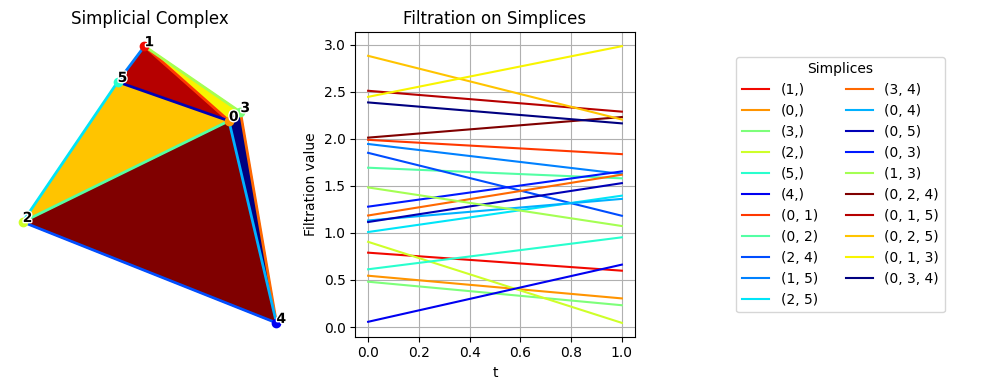

In [35]:
n = 6
dim = 2
points = np.random.random([n, dim])

simplices = np.array([tuple(s) for s, _ in gh.AlphaComplex(points).create_simplex_tree().get_simplices()], dtype=object)
simplices = simplices[np.argsort([len(s) for s in simplices])]
dims = np.vectorize(len)(simplices) - 1

filtration0 = np.random.random(len(simplices)) + dims
filtration1 = np.random.random(len(simplices)) + dims

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

colors = np.linspace(0, 1, len(simplices))
colors = np.random.choice(colors, len(colors), replace=False)
colors = plt.get_cmap('jet')(colors)
lines = []
labels = []

for i in range(len(simplices)):
    plot_simplex(list(simplices[i]), points, color=colors[i], ax=axs[0])
    
    line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])
    lines.append(line)
    labels.append(str(simplices[i]))

axs[0].set_title('Simplicial Complex')
axs[0].axis('off')
enumerate_points(points, ax=axs[0], weight='semibold', forewidth=2)

axs[1].set_title('Filtration on Simplices')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Filtration value')
axs[1].grid(True)

axs[2].axis('off')
axs[2].legend(lines, labels, loc='center', title="Simplices", ncol=2)

plt.tight_layout()
plt.show()

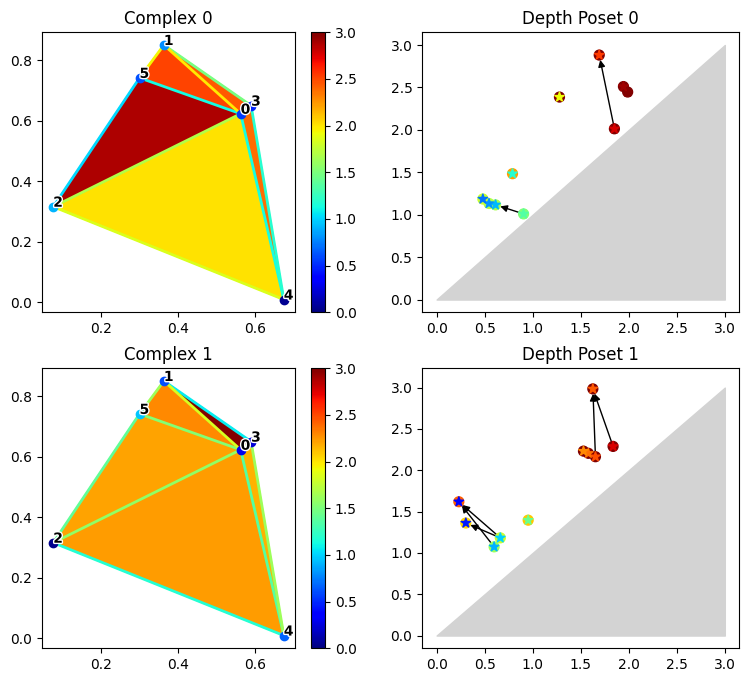

In [49]:
stree0 = gh.SimplexTree()
for simplex, value in zip(simplices, filtration0):
    stree0.insert(simplex, value)
dp0 = DepthPoset.from_simplex_tree(stree0)

stree1 = gh.SimplexTree()
for simplex, value in zip(simplices, filtration1):
    stree1.insert(simplex, value)
dp1 = DepthPoset.from_simplex_tree(stree1)

cmap = plt.get_cmap('jet')
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
for i, (streei, dpi) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Complex {i}')
    sm = plot_filtred_complex2d(streei, points, ax=axs[i, 0], cmap=cmap, vmin=0, vmax=dim+1)
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0], weight='semibold', forewidth=2)
    
    birth_colors = [cmap(streei.filtration(node.source[0])/dim) for node in dpi.nodes]
    death_colors = [cmap(streei.filtration(node.source[1])/dim) for node in dpi.nodes]

    axs[i, 1].set_title(f'Depth Poset {i}')
    nx.draw_networkx_edges(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, hide_ticks=False)
    nx.draw_networkx_nodes(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, node_shape='o', node_color=death_colors, hide_ticks=False)
    nx.draw_networkx_nodes(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, node_shape='*', node_color=birth_colors, hide_ticks=False)
    
    axs[i, 1].fill_between([0, dim + 1], [0, 0], [0, dim + 1], color='lightgrey')

# Transposition Classification Functions

# Define the Transposition Moments

In [37]:
def get_cross_parameters(y0, y1, t0=0, t1=1, filter_outside=True):
    """
    Returns the matrix of cross parameters between two arrays.

    Parameters:
        y0, y1: two arrays of the same length
        t0, t1: the time points for the arrays
        filter_outside: if True, filter out the values outside the range [t0, t1]

    Returns:
        cross_parameters: the matrix of cross parameters
    """
    y0 = np.asarray(y0)
    y1 = np.asarray(y1)
    if y0.shape != y1.shape:
        raise ValueError("Arrays must have the same length.")
    if y0.ndim != 1:
        raise ValueError("Arrays must be 1D.")
    
    yi0 = y0.reshape(-1, 1)
    yi1 = y1.reshape(-1, 1)
    yj0 = y0.reshape(1, -1)
    yj1 = y1.reshape(1, -1)

    cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


    if filter_outside:
        cross_parameters[cross_parameters < min(t0, t1)] = np.nan
        cross_parameters[cross_parameters > max(t0, t1)] = np.nan
    return cross_parameters

In [41]:
cross_parameters = [get_cross_parameters(filtration0[dims == i], filtration1[dims == i]) for i in range(dim)]

eps = 0.8*min([min(np.unique(np.triu(i))[1:-1] - np.unique(np.triu(i))[:-2]) for i in cross_parameters])
eps

/tmp/ipykernel_63471/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


np.float64(0.000773137530082746)